In [1]:
import pandas as pd
from datasets import Dataset
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

In [2]:
df = pd.read_csv('train_v2_drcat_02.csv')

In [3]:
df_shuffled = df.sample(frac=1, random_state=42)

In [4]:
df_shuffled = df_shuffled.drop_duplicates(subset=['text'])


In [5]:
df_shuffled.reset_index(drop=True, inplace=True)

In [6]:
df_shuffled.shape

(44868, 5)

In [7]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [8]:
split_index = int(0.7 * len(df_shuffled))

In [9]:
train = df_shuffled.iloc[:split_index]
test = df_shuffled.iloc[split_index:]

In [10]:
train.shape

(31407, 5)

In [11]:
test.shape

(13461, 5)

In [12]:
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

In [13]:
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])

In [14]:
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]

In [15]:
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

In [16]:
dataset = Dataset.from_pandas(test[['text']])

In [17]:
def train_corp_iter():
        for i in range(0, len(dataset), 1000):
            yield dataset[i: i + 1000]["text"]

In [18]:
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

In [19]:
tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=raw_tokenizer,
        unk_token="[UNK]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        sep_token="[SEP]",
        mask_token="[MASK]",
    )

In [20]:
tokenized_texts_test = []

In [21]:
for text in tqdm(test['text'].tolist()):
        tokenized_texts_test.append(tokenizer.tokenize(text))

  0%|          | 0/13461 [00:00<?, ?it/s]

In [22]:
tokenized_texts_train = []


In [23]:
for text in tqdm(train['text'].tolist()):
        tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/31407 [00:00<?, ?it/s]

In [24]:
def dummy(text):
        return text

In [25]:
vectorizer1 = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer='word',tokenizer=dummy, preprocessor=dummy,token_pattern=None, strip_accents='unicode')

In [26]:
vectorizer1.fit(tokenized_texts_test)

TfidfVectorizer(lowercase=False, ngram_range=(3, 5),
                preprocessor=<function dummy at 0x0000029324449090>,
                strip_accents='unicode', sublinear_tf=True, token_pattern=None,
                tokenizer=<function dummy at 0x0000029324449090>)

In [28]:
vocab = vectorizer1.vocabulary_

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,analyzer='word', tokenizer=dummy, preprocessor=dummy,token_pattern=None, strip_accents='unicode')

In [30]:
tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

In [31]:
y_train = train['label'].values

In [32]:
clf = MultinomialNB(alpha=0.02)

In [33]:
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")

In [34]:
clf.fit(tf_train, y_train)

MultinomialNB(alpha=0.02)

In [35]:
sgd_model.fit(tf_train, y_train)

SGDClassifier(loss='modified_huber', max_iter=8000, tol=0.0001)

In [36]:
tf_test

<13461x10392384 sparse matrix of type '<class 'numpy.float64'>'
	with 16916026 stored elements in Compressed Sparse Row format>

In [37]:
p1 = clf.predict(tf_test)

In [38]:
p1

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [39]:
actual = test['label']

In [40]:
acc = clf.score(tf_test , actual)

In [41]:
acc

0.9880395215808633

In [42]:
acc2 = sgd_model.score(tf_test , actual)

In [43]:
acc2 

0.9801649208825496

In [44]:
#joblib.dump((clf, tokenizer, vectorizer1), 'model_preprocessed.pkl')

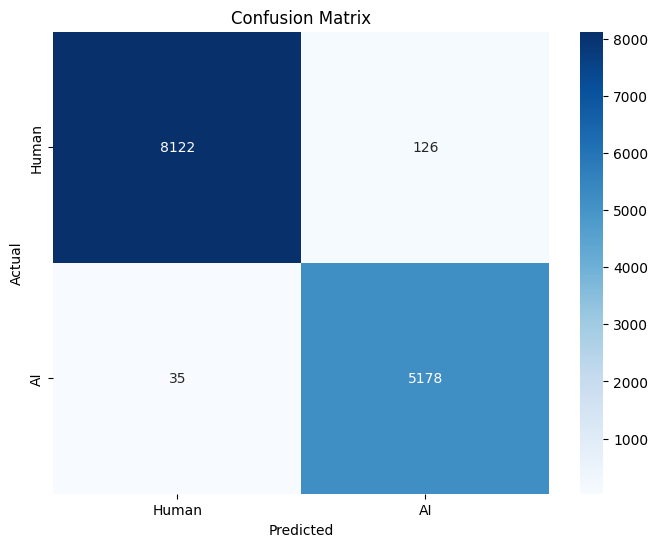

Classification Report:
               precision    recall  f1-score   support

       Human       1.00      0.98      0.99      8248
          AI       0.98      0.99      0.98      5213

    accuracy                           0.99     13461
   macro avg       0.99      0.99      0.99     13461
weighted avg       0.99      0.99      0.99     13461



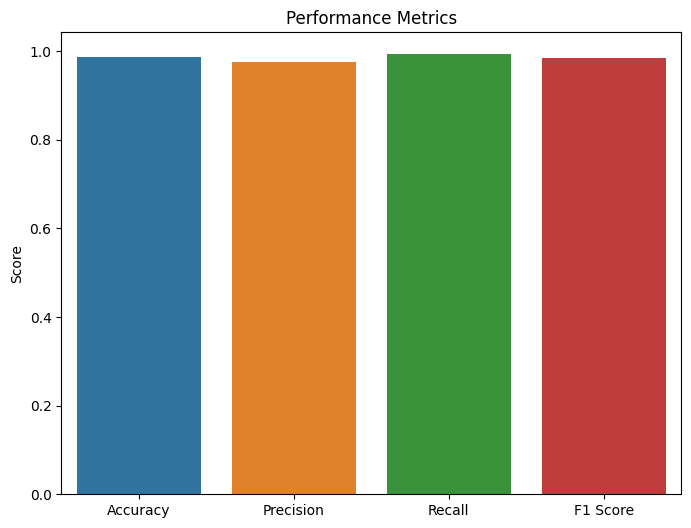

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate predictions for the entire test set
y_pred = clf.predict(tf_test)

# Confusion Matrix
cm = confusion_matrix(test['label'].values, y_pred)

# Classification Report
report = classification_report(test['label'].values, y_pred, target_names=['Human', 'AI'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Classification Report
print("Classification Report:\n", report)

# Plot Performance Metrics
accuracy = np.sum(y_pred == test['label'].values) / len(test)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
f1_score = 2 * (precision * recall) / (precision + recall)

metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}
plt.figure(figsize=(8, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.show()
